# Factors Which Influence User Ratings on BoardGameGeek

In [2]:
## setup cell

# import required libraries
import pickle as pickle
import math as math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.graphics.gofplots import ProbPlot
import statsmodels.api as sm


## load and process dataset for figures below
# load the dataset
with open("Objects/20181120_sample_pickle", "rb") as file:
    bgg_data = pickle.load(file)
    
# cast the dataset's columns into the appropriate type
bgg_data[["Rating", "Weight", "Average Rating"]] = bgg_data[["Rating", "Weight", "Average Rating"]].astype(float)
bgg_data[["ID", "Rating Number", "Release Year", "Owners", "Registration Year"]] = bgg_data[["ID", "Rating Number", "Release Year", "Owners", "Registration Year"]].astype(int)

## create fields for evaluating the name
# field for length of name
bgg_data["Name Length"] = bgg_data["Name"].apply(len)

# field for place in alphabetical order
bgg_data["Name Alphabetical"] = bgg_data["Name"].apply(
    lambda x:
            {"0": 0, "1": 0, "2": 0, "3": 0, "4": 0, "5": 0, "6": 0, "7": 0, "8": 0, "9": 0,
            "a": 1, "b": 2, "c": 3, "d": 4, "e": 5, "f": 6, "g": 7, "h": 8, "i": 9, "j": 10,
            "k": 11, "l": 12, "m": 13, "n": 14, "o": 15, "p": 16, "q": 17, "r": 18, "s": 19,
            "t": 20, "u": 21, "v": 22, "w": 23, "x": 24, "y": 25, "z": 26}[x[0].lower()]
)

# remove observations with games released prior to 1990 from the dataset
bgg_1990 = bgg_data[bgg_data["Release Year"] >= 1990]

# sort out duplicate rows using Name as the key value
bgg_1990 = bgg_1990.drop_duplicates(subset = "Name")

# log transform Owners and Name Length
bgg_1990["log Owners"] = bgg_1990["Owners"].apply(math.log)
bgg_1990["log Name Length"] = bgg_1990["Name Length"].apply(math.log)

# transform years
bgg_1990["Delta Release"] = bgg_1990["Release Year"].apply(lambda x: x - 1990)
bgg_1990["Delta Registration"] = bgg_1990["Registration Year"].apply(lambda x: x - 2000)

### Introduction
User ratings are omnipresent in our current culture, appearing prominantly alongside items in digital storefronts, biasing distribution on social media platforms, and rating users themselves in peer-to-peer commerce applications. Due to this ubiquity, leveraging the factors that correlate with higher user ratings provides a distinct advantage for the rated entities, whether they are a clothing company launching a new line or a ride-sharing driver appealing to passengers.

The hobby board game industry, once little more than a relatively small cluster of importers, has grown tremendously over the past decades into a crowded marketplace containing corporate conglomerates competing directly with Kickstarter projects. As such, there is no less pressure to understand user behavior than in any other consumer-facing industry.

BoardGameGeek is a hobbyist website devoted to cataloguing board games, including user-generated data in the form of ratings, reviews, and discussion forums. The de facto standard for board game enthusiasts to discover games, appearing highly in the BoardGameGeek rankings adds significant discoverability to a new release. Thus, understanding the factors associated with higher user ratings provides a competitive advantage in the hobby boardgame market.

In this work, we will repurpose a dataset of user ratings and associated features pulled from BoardGameGeek into an observational study and evaluate the degree of association in an effort to better understand what leads to a high ranking on BoardGameGeek.

### Composition of Dataset
The dataset for this analysis was a simple random sample of 10,000 user ratings drawn from the population of all user ratings for the top 2500 ranked games on BoardGameGeek on November 17, 2018. Initially produced in pursuit of a different hypothesis, this study repurposed the dataset by dropping duplicate ratings based on board game name, leaving ~1800 unique observations. In addition to the average user rating, each observation contained the following notable features:

- Game Name
- Game Release Year
- Weight (Game Complexity)
- Number of Owners

Several explanatory variables were transformed prior to analysis. In order to improve the interpretability of the final model, game release year was encoded as years elapsed since 1990. The number of owners and name length were exponentially and Poisson distributed, respectively, and were thus logarithm-transformed in anticipation of outlier values.

Two explanatory variables were derived from the game name: name length, a simple count of characters in the name, and an approximation of the game name's position in alphabetical order generated by assigning each letter an integer value from 1 to 26 with numeric characters assigned 0.

Additionally, we elected to remove games released prior to the start of the era of modern board games, approximately 1990, under the assumption that user ratings for ancient games such as Chess or Go are driven by different factors than user ratings for games released in the modern board game era. Our hypothesis was adjusted accordingly.

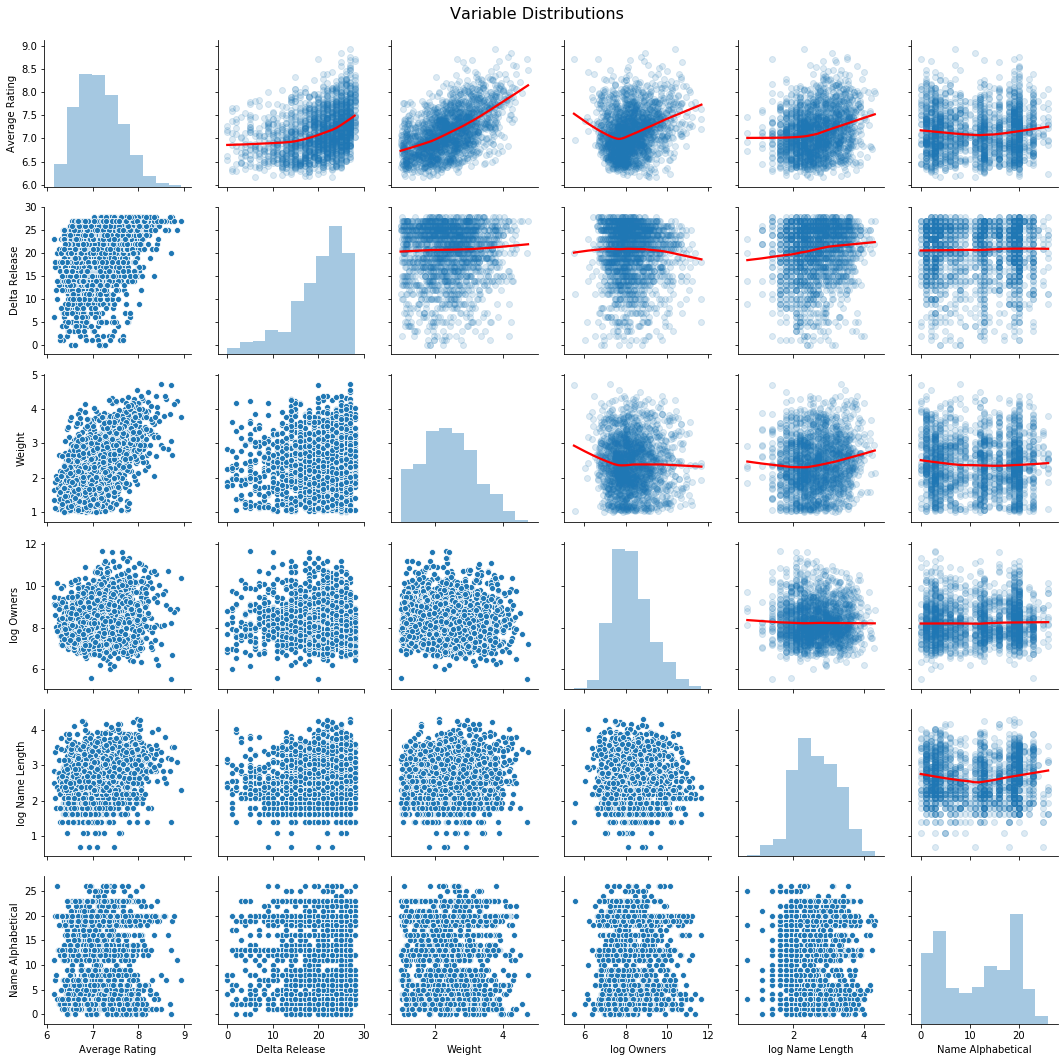

In [35]:
## pairs plot of variables
# breakout the needed columns from the larger dataset
to_plot = bgg_1990[["Average Rating", "Delta Release", "Weight", "log Owners", "log Name Length", "Name Alphabetical"]]

# generate a pairs plot
pairs = sns.PairGrid(to_plot)
pairs = pairs.map_upper(sns.regplot, lowess = True, scatter_kws = {"alpha": 0.15}, line_kws = {"color": "red"})
pairs = pairs.map_diag(sns.distplot, kde = False, bins = 10)
pairs = pairs.map_lower(sns.scatterplot)

# add a title, display plot
plt.subplots_adjust(top = 0.95)
plt.suptitle("Variable Distributions", fontsize = 16)
plt.show()

### Methods

#### Hypothesis

The alternative hypthothesis was: *For board games released after 1990, the average user rating is correlated with the game's release year, weight, total owners, length of name, and place in alphabetical order.*

We set $\alpha$ = 0.05 and used the Bonferonni correction for multiple hypothesis testing.

#### Model Selection
We initially selected a multivariate linear regression for evaluation of our hypothesis. Potential nonlinearities were observed in the relationship between the average rating and several explanatory variables, so quadratic terms were added to the model, keeping those that provided a significant effect of relevant magnitude.

The residuals from the uncorrected model were found to deviate from normality with a broadening of the distribution tails. In order to mitigate the effect of the outlier residuals on the coefficient estimates, we refit the model using a robust linear regression with a biweight weighting function.

#### Selected Model
$Rating_{avg} = \sum{X_i\beta_i}$

|  Predictor ($X_i$)  |  Coefficient ($\beta_i$)  |  p  |  95% Confidence Interval  |
| --- | --- | --- | --- |
|  (intercept)  |  9.4  |  <0.0001  |  [8.5, 10.3]  |
|  Release Year  |  -0.057  |  <0.0001  |  [-0.068, -0.045]  |
|  Release Year^2  |  2.4e-3  |  <0.0001  |  [2.0e-3, 2.7e-3]  |
|  Weight  |  0.35  |  <0.0001  |  [0.33, 0.37]  |
|  log(Owners)  |  -0.90  |  <0.0001  |  [-1.1, -0.69]  |
|  log(Owners)^2  |  0.061  |  <0.0001  |  [0.048, 0.073]  |
|  log(Name Length)  |  0.090  |  <0.0001  |  [0.066, 0.11]  |
|  Name Alphabetical  |  1.8e-3  |  0.077  |  [0.0, 3.8e-3]  |

### Results and Discussion

With Bonferonni correction for multiple comparison giving a significance threshold of 0.007, we did not find evidence that the position of the game's name in alphabetical order was significantly associated with the average user ratings.

Game weight was found to be significantly associated, with an increase of 1 unit of weight resulting in an increase of 0.35 rating points. The magnitude of this effect is notable, with the simplest games (weight 1) receiving ratings on average 1.4 rating points higher than the most complex (weight 5).

Similarly, the length of the game's name was found to be significantly associated, with a 1% increase in name length resulting in an increase of 0.09 rating points. This magnitude of this effect is relatively small in the range of an average length name, but indicates that using exceedingly short names for board games is not necessarily an ideal choice.

The number of owners was found to be significantly associated, with a nonlinear relationship to the average rating. Initially, user ratings decrease with increased owners; however, this trend quickly reverses as games accumulate more than 2,000 owners, peaking significantly above the original rating. The magnitude of this effect is relatively large, representing a difference of over a rating point from the least to most owned games.

Similarly, the year of release was found to be significantly associated, with a nonlinear relationship to the average rating. The average rating decreases until 2002, at which point it begins to rise again, peaking above the starting point. The magnitude of this effect is less than the number of owners but still large enough to need to be accounted for.

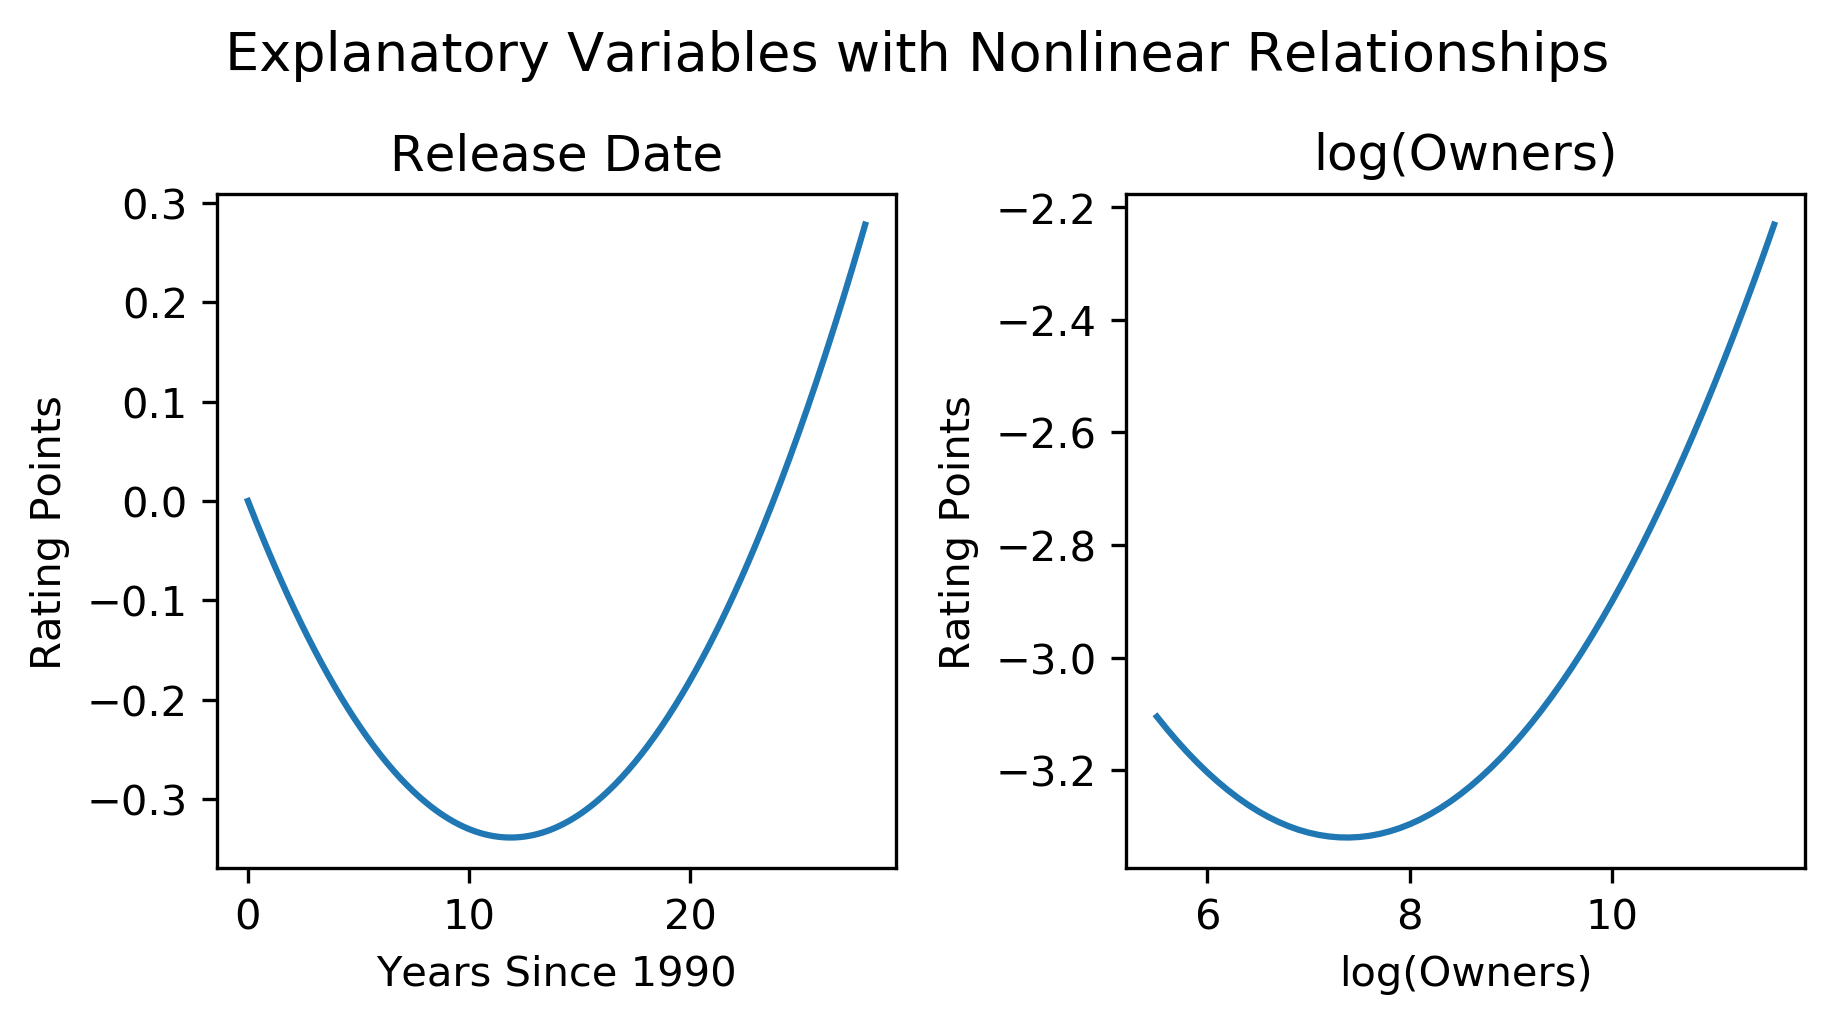

In [5]:
## isolated effects of nonlinear explanatory variables
# start a figure
fig, ax = plt.subplots(1, 2, figsize = (6, 3.3), dpi = 300, constrained_layout = True)

# generate mock data for plotting
x1 = np.arange(bgg_1990["Delta Release"].min(), bgg_1990["Delta Release"].max(), 0.1)
y1 = -0.057 * x1 + 0.0024 * x1**2
x2 = np.arange(bgg_1990["log Owners"].min(), bgg_1990["log Owners"].max(), 0.1)
y2 = -0.90 * x2 + 0.061 * x2**2

# add line plots
ax[0].plot(x1, y1)
ax[0].title.set_text("Release Date")
ax[0].set_xlabel("Years Since 1990")
ax[0].set_ylabel("Rating Points")
ax[1].plot(x2, y2)
ax[1].title.set_text("log(Owners)")
ax[1].set_xlabel("log(Owners)")
ax[1].set_ylabel("Rating Points")

# add an overall title, show the figure
fig.suptitle("Explanatory Variables with Nonlinear Relationships", fontsize = "13")
plt.show()

### Conclusion

We explored the contribution of game weight, the length of the game's name, and the alphabetical positioning of the name on the average user rating given to the board game on BoardGameGeek, correcting for year of release and number of owners. From this analysis, we can conclude that more complex games receive higher average ratings. Additionally, we learned that games with very short titles tend to be less well received, and that games with names appearing toward the front of the alphabet have no significant advantage over those at the end.

Given that this work repurposed a dataset collected in pursuit of a different study, there are a number of fields available from BoardGameGeek that would be of interest that were not included: the number of players supported, the time required to play the game, the dependence of the game on text versus iconography, and the game's theming. Augmenting the existing dataset with these additional features is the next step to take toward the goal of producing actionable insight into the tastes of hobby board game players.